<a href="https://colab.research.google.com/github/yaroslavpod/ARD/blob/main/ds6_06_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithms for Big Data - Exercise 6
This lecture is focused on the basic examples of the RNN usage for time series forecasting.

We will use Amazon stocks dataset from Yahoo finance. You can take look at this [this](https://finance.yahoo.com/quote/AMZN?p=AMZN)

Other datasets are also available, we will show you how to create your own as well.


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_06.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_06.ipynb)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [ ]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

# We have prepared Apple datasets for our experiments


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/SNE.csv')
df.index = pd.to_datetime(df.Date)
df = df.drop('Date', axis=1)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-25,33.689999,34.000000,33.500000,33.560001,30.684494,579800
2010-10-26,33.820000,34.020000,33.630001,33.910000,31.004501,1042800
2010-10-27,33.759998,33.900002,33.389999,33.849998,30.949646,709300
2010-10-28,33.680000,33.970001,33.630001,33.820000,30.922213,1116400
2010-10-29,33.880001,34.259998,33.560001,33.840000,30.940502,1162400


# We are interested only in the Open column, which we will forecast
## We will deal with univariate time series forecasting in this lecture

In [ ]:
df = pd.DataFrame({'Price': df.iloc[:, 0]})

# The first step in every analysis task is taking a look at the data

In [ ]:
def show_timeseries(df):
    figsize = 20
    plt.figure(figsize=(figsize,figsize/2))
    plt.plot(df.index, df)
    plt.ylabel('Price ($)')
    plt.xlabel('Datetime')

# We can see that the stock price has significant trend and there are short term fluctuations as well

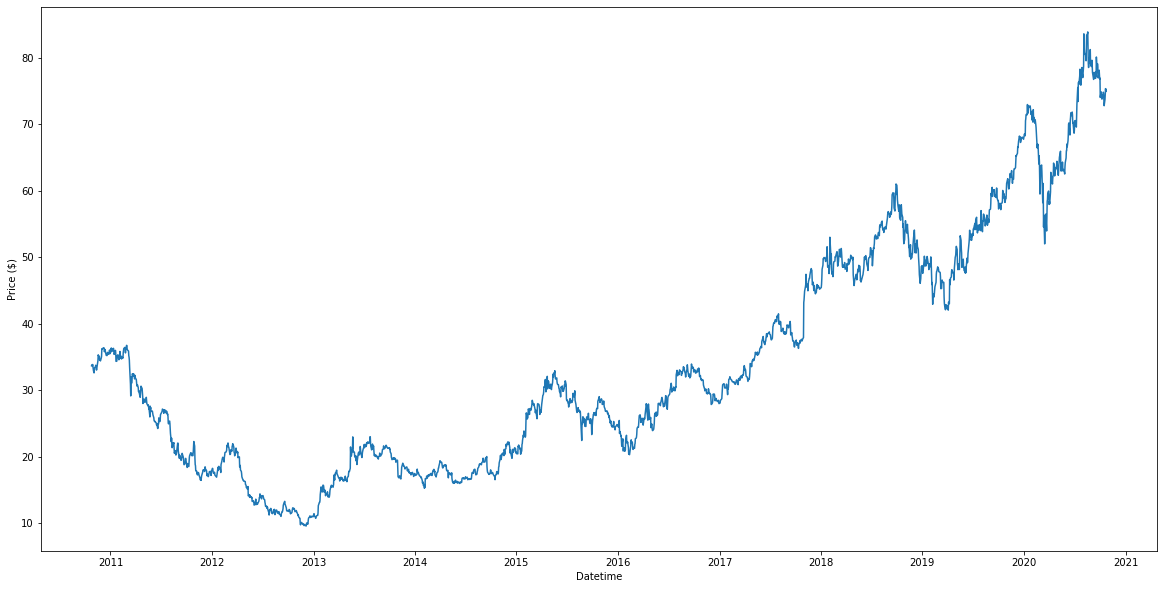

In [ ]:
show_timeseries(df)

# We worked with the classification models in the last few weeks
We evaluated quality of every created models based on its accuracy.

Accuracy is only one of the many metrics for the classification task but it is the simples one (take a look at the F1-Score, AuC/ROC, Precision/recall metrics if you are interested in this area).

Forecasting and regression tasks are not different - we have to evaluate model quality as well, butut now we use different types of metrics - most basic ones are MAE, RMSE which we already encountered.
There are many more metrics - R2, MAPE, sMAPE etc.

We have prepared the evaluation functions API for you.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

# Now we will create the three datasets

In [ ]:
maxlag = 60
df_orig = df.copy()
df_orig.Price = df_orig.Price.diff(2)

In [ ]:
for x in range(1, maxlag):
    df_orig[f'Price_lag_{x}'] = df_orig.Price.shift(x)

In [ ]:
X_train, y_train = X[X.index.year < 2019], y[X.index.year < 2019]
X_valid, y_valid = X[(X.index.year == 2019) & (X.index.month <= 6)], y[(X.index.year == 2019) & (X.index.month <= 6)]
X_test, y_test = X[(X.index.year == 2019) & (X.index.month > 6)], y[(X.index.year == 2019) & (X.index.month > 6)]

In [ ]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [ ]:
X_test_idx = X_test.index

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])

In [ ]:
inp = keras.layers.Input(shape=X_train.shape[1:])
x = keras.layers.LSTM(512, activation='mish', return_sequences=True)(inp)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(256, activation='mish', return_sequences=True)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, activation='linear')(x)


model = keras.Model(inp, output_layer)
model.summary()
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mae'])

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 59)]           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 512)            1171456   
_________________________________________________________________
batch_normalization_21 (Batc (None, 1, 512)            2048      
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
batch_normalization_22 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_20 (Dense)             (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_23 (Batc (None, 1, 128)          

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 32
epochs = 70
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/70
63/63 [==============================] - 1s 18ms/step - loss: 1.5964 - mae: 0.9283 - val_loss: 0.9296 - val_mae: 0.7003
Epoch 2/70
63/63 [==============================] - 1s 14ms/step - loss: 0.8155 - mae: 0.6783 - val_loss: 0.9254 - val_mae: 0.6973
Epoch 3/70
63/63 [==============================] - 1s 11ms/step - loss: 0.6671 - mae: 0.6112 - val_loss: 0.9258 - val_mae: 0.6969
Epoch 4/70
63/63 [==============================] - 1s 11ms/step - loss: 0.5286 - mae: 0.5478 - val_loss: 0.9263 - val_mae: 0.6981
Epoch 5/70
63/63 [==============================] - 1s 11ms/step - loss: 0.4797 - mae: 0.5170 - val_loss: 0.9252 - val_mae: 0.6974
Epoch 6/70
63/63 [==============================] - 1s 11ms/step - loss: 0.3949 - mae: 0.4676 - val_loss: 0.9252 - val_mae: 0.6949
Epoch 7/70
63/63 [==============================] - 1s 14ms/step - loss: 0.3373 - mae: 0.4342 - val_loss: 0.9275 - val_mae: 0.6999
Epoch 8/70
63/63 [==============================] - 1s 13ms/step - loss: 0.3177 - m

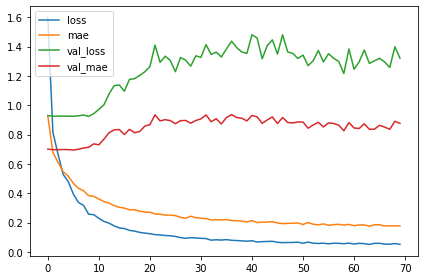

In [ ]:
show_history(history)

In [ ]:
y_pred = model.predict(X_test)
df_res = pd.DataFrame({'y_pred': y_pred.reshape(-1), 'y_true': y_test}).dropna()

In [ ]:

compute_metrics(df_res)

,MAE,MSE,MAPE,SMAPE,R2
0,0.665986,0.69478,214.83986,149.576529,-0.475431


In [ ]:

def show_forecasts(df_res):
    figsize = 20
    plt.figure(figsize=(figsize,figsize/2))
    plt.plot(df_res.index, df_res.y_true, color='red')
    plt.plot(df_res.index, df_res.y_pred, color='green')
    plt.ylabel('Price ($)')
    plt.xlabel('Datetime')

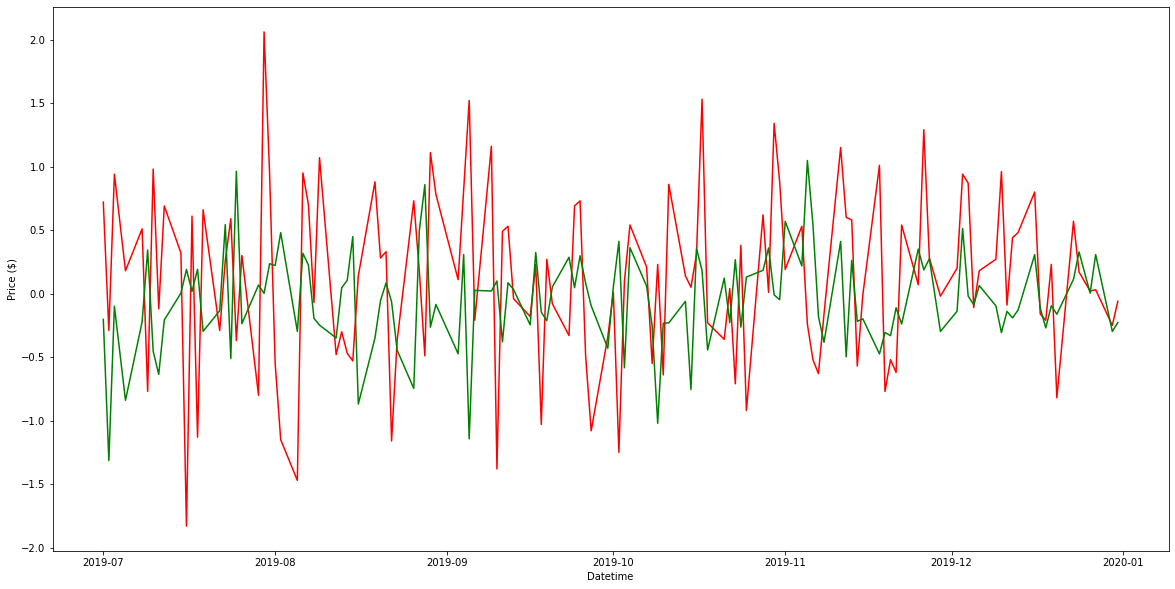

In [ ]:
show_forecasts(df_res)

# Task for the lecture

 - Choose other stock prices dataset
 - Try to create your own architecture using reccurent neural networks
 - Experiment a little - try different batch sizes, optimimizers, time lags as features, etc
 - Send me the Colab notebook with results and description what you did and your final solution!